# hSVM and logistic regression
> Benchmarking two more hyperbolic classifiers

In [1]:
%load_ext autoreload
%autoreload 2

# hSVM and hMLR benchmark:

This code should be run using the `hsvm` conda environment instead of the `hdt` conda environment.

Source for hSVM code:
`https://github.com/plumdeq/hsvm/blob/master/hsvm.py`

Source for HLR code:
`https://github.com/kschwethelm/HyperbolicCV/blob/main/code/lib/lorentz/layers/LMLR.py`


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# hSVM stuff
sys.path.append("../hsvm")
from hsvm import LinearHSVM

# hLR stuff
sys.path.append("../HyperbolicCV/code")
from lib.lorentz.layers.LMLR import LorentzMLR
from lib.lorentz.manifold import CustomLorentz
import torch

# Euclidean versions
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# For benchmarking
# from hyperdt.toy_data import wrapped_normal_mixture
sys.path.append("../HoroRF")
from datasets.gaussian import get_training_data, get_testing_data

# from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score
import time
from tqdm import tqdm_notebook as tqdm

/home/phil/hdt/notebooks/../hsvm/htools.py:29: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)
/home/phil/hdt/notebooks/../hsvm/htools.py:108: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)
INFO:root:Using numpy backend


In [65]:
# Suppress UserWarning from sklearn and FutureWarning from numba
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [66]:
# Train hMLR function


def train_hmlr(X, y, steps=1000):
    # Init class...
    hmlr = LorentzMLR(num_features=X.shape[1], num_classes=2, manifold=CustomLorentz())

    # hMLR outputs logits; labels are {0, 1}
    opt = torch.optim.Adam(hmlr.parameters(), lr=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    for _ in range(steps):
        opt.zero_grad()
        logits = hmlr(X)
        loss = loss_fn(logits[:, 1], y)
        loss.backward()
        opt.step()

    return hmlr

In [67]:
results = pd.DataFrame(columns=["seed", "n_dim", "model", "f1_score", "time"])

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dims = [2, 4, 8, 16]
my_tqdm = tqdm(total=len(seeds) * len(dims) * 4 * 5)


def train_predictor(predictor_class, X_train, y_train, X_test, y_test):
    # Run the predictor
    t1 = time.time()
    predictor = predictor_class()
    if predictor_class == LinearHSVM:
        y_train = y_train.detach().clone()
        y_train[y_train == 0] = -1
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    if predictor_class == LinearHSVM:
        y_pred[y_pred == -1] = 0
    t2 = time.time()
    score = f1_score(y_test, y_pred, average="micro")

    return score, t2 - t1


for n_dim in dims:
    for seed in seeds:
        # print(n_dim, seed)
        my_tqdm.set_description(f"{n_dim}, {seed}")
        X, y = get_training_data(class_label=n_dim, seed=seed, num_samples=int(800 / 0.8), convert_to_poincare=False)

        # Both models like hyperboloids, so this is easy
        folds = KFold(n_splits=5, shuffle=True, random_state=seed)

        for train_index, test_index in folds.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train_torch = torch.tensor(X_train, dtype=torch.float)
            y_train_torch = torch.tensor(y_train, dtype=torch.float)
            X_test_torch = torch.tensor(X_test, dtype=torch.float)
            y_test_torch = torch.tensor(y_test, dtype=torch.float)

            for predictor_class in [LinearHSVM, SVC, LogisticRegression]:
                score, t = train_predictor(predictor_class, X_train, y_train, X_test, y_test)
                results.loc[len(results)] = [seed, n_dim, predictor_class.__name__, score, t]
                my_tqdm.update()

            # hMLR
            t1 = time.time()
            hmlr = train_hmlr(X_train_torch, y_train_torch)
            y_pred = hmlr(X_test_torch).argmax(dim=1).clone().detach().numpy()
            t2 = time.time()
            hmlr_score = f1_score(y_test, y_pred, average="micro")
            results.loc[len(results)] = [seed, n_dim, "hMLR", hmlr_score, t2 - t1]
            my_tqdm.update()

            # Postfix
            my_tqdm.set_postfix(hSVM=hsvm_score, hMLR=hmlr_score, SVM=svm_score, LR=lr_score)

results.to_csv("../data/processed/hsvm_hmlr_results.csv")

In [35]:
results = pd.read_csv("../data/processed/hsvm_hmlr_results.csv")
hyperdt_results = pd.concat(
    [
        pd.read_table("../data/processed/hororf_benchmarks/md3_dt_results.tsv"),
        pd.read_table("../data/processed/hororf_benchmarks/md3_dt_results_2.tsv"),
    ]
)
hyperdt_results = hyperdt_results[
    (hyperdt_results["clf"] == "hrf")
    & (hyperdt_results["dataset"] == "gaussian")
    & (hyperdt_results["n_samples"] == 800)
]
# hyperdt_times = pd.concat(
#     [
#         pd.read_table("../data/processed/hororf_benchmarks/md3_dt_times.tsv"),
#         pd.read_table("../data/processed/hororf_benchmarks/md3_dt_times_2.tsv"),
#     ]
# )
# hyperdt_merged = pd.merge(hyperdt_results, hyperdt_times, on=["dataset", "n_samples", "dim", "seed", "clf", "fold"], how="left")
# print(len(hyperdt_merged))

# Fix columns
hyperdt_results = hyperdt_results[["dim", "seed", "clf", "fold", "f1_micro"]]
hyperdt_results
results = results[["n_dim", "seed", "model", "f1_score"]]
results.columns = ["dim", "seed", "clf", "f1_micro"]

results_merged = pd.concat([results, hyperdt_results])

In [38]:
# Generate LaTeX table

results_grouped = pd.pivot_table(results_merged, index="dim", columns="clf", values="f1_micro", aggfunc=np.mean) * 100
results_grouped = results_grouped[["LogisticRegression", "hMLR", "LinearHSVM", "SVC", "hrf"]]
results_grouped.to_latex("../data/processed/hsvm_hmlr_results.tex", float_format="%.2f")
results_grouped

clf,LogisticRegression,hMLR,LinearHSVM,SVC,hrf
dim,,,,,
2,90.1125,88.6500,81.5000,80.9625,91.8750
4,99.2000,99.4125,96.9375,85.5625,99.3000
8,99.9750,99.9625,100.0000,79.0625,99.9625
16,99.9875,100.0000,98.1250,86.9875,100.0000


In [54]:
# Statistical significance tests: just against hrf

# A bunch of t-tests:
from scipy.stats import ttest_rel
from warnings import filterwarnings

for dim in [2, 4, 8, 16]:
    for clf in ["LogisticRegression", "hMLR", "LinearHSVM", "SVC"]:
        # NaNs came up in some perfect scoring cases, so that's why we have to fillna(1):
        arr1 = results_merged[(results_merged["clf"] == clf) & (results_merged["dim"] == dim)]["f1_micro"].fillna(1)
        arr2 = results_merged[(results_merged["clf"] == "hrf") & (results_merged["dim"] == dim)]["f1_micro"].fillna(1)
        t, p = ttest_rel(arr1, arr2)
        if p < 0.05:
            print(f"{clf} vs hrf on dim {dim}: p = {p}")

LogisticRegression vs hrf on dim 2: p = 0.0003868582222425373
hMLR vs hrf on dim 2: p = 0.0021577407927920278
LinearHSVM vs hrf on dim 2: p = 0.00042877054901700387
SVC vs hrf on dim 2: p = 1.1803908178262793e-10
LinearHSVM vs hrf on dim 4: p = 0.0180403238920398
SVC vs hrf on dim 4: p = 2.6879297682435276e-13
SVC vs hrf on dim 8: p = 3.843971096444841e-15
LinearHSVM vs hrf on dim 16: p = 0.01794215016892341
SVC vs hrf on dim 16: p = 8.380525966816982e-17


<Axes: xlabel='n_dim'>

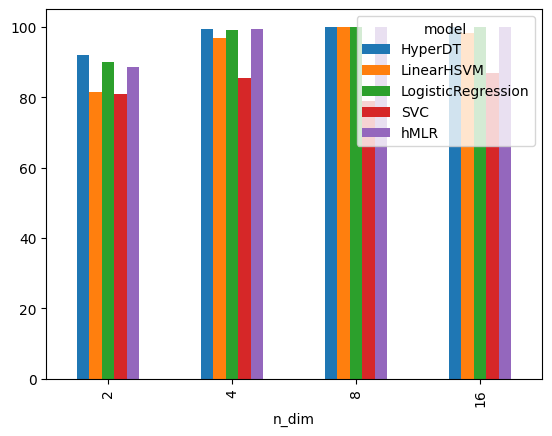

In [73]:
# Basic bar plot

results_grouped.pivot(index="n_dim", columns="model", values="f1_score").plot.bar()